# Titanic Dataset

## Setup

### Include all libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
%matplotlib inline

np.__version__, pd.__version__, sklearn.__version__, sns.__version__

('1.23.4', '1.5.0', '1.1.3', '0.12.0')

In [4]:
%load_ext version_information
%version_information

Software versions
Python 3.10.8 64bit [GCC 10.2.1 20210110]
IPython 8.6.0
OS Linux 5.10.104 linuxkit aarch64 with glibc2.31
Thu Nov 24 07:26:01 2022 UTC

### Download dataset

Please manually download the two datasets `train.csv` from [here](https://www.kaggle.com/competitions/titanic/data) into the folder `data`.

In [20]:
import os

train_csv_path = 'data/train.csv'

while not os.path.isfile(train_csv_path):
    print('Please sign in to Kaggle and download the dataset `train.csv` into the folder `data`.')
    input('Press Enter to continue...')

In [22]:
raw_df = pd.read_csv('data/train.csv')

## Data preparation

Ausgabe der ersten 5 Datensätze und des shapes des Datensatzes:

In [23]:
raw_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [24]:
raw_df.shape

(891, 12)

Ausgabe aller Spaltennamen und datentypen:

In [25]:
raw_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [26]:
raw_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [35]:
for column in raw_df:
    if (raw_df[column].isnull().sum()):
        print(f'{column}: {raw_df[column].isnull().sum()} null values')

Age: 177 null values
Cabin: 687 null values
Embarked: 2 null values


Aufbereitung des Datensatzes:

In [52]:
def prepare_raw_data_frame(df):
    # Entferne nicht benötigte Spalten 
    df = df.drop(['Name', 'Ticket'], axis=1)
    # Entferne Spalten mit fehlenden Werten
    df = df.drop(['Cabin'], axis=1)
    # Entferne die beiden Datensätze mit fehlenden `Embarked` Werten
    df = df.dropna(axis=0, subset=['Embarked'])
    # Berechne fehlende `Age` Werte
    df['Age'] = df.groupby(['Pclass','Sex'])['Age'].transform(lambda x: x.fillna(x.median()))
    # Berechne fehlende `Fare` Werte
    df['Fare'] = df.groupby(['Pclass','Sex'])['Fare'].transform(lambda x: x.fillna(x.median()))
    # Ersetze kategorische Werte mit dummy variablen
    df['Sex'] = df['Sex'].replace({'male': 0, 'female': 1})
    df['Embarked'] = df['Embarked'].replace({'S': 0, 'C': 1, 'Q': 2})
    # Spalten neu ordnen
    df = df[['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Survived']]
    # Spalten umbenennen
    df = df.rename(columns={'Pclass': 'TicketClass', 'SibSp': 'NumOfSiblingsAndSpouses', 'Parch': 'NumOfParentsAndChildren', 'Embarked': 'PortOfEmbarkation' })
    return df

df = prepare_raw_data_frame(raw_df)
df.head()

,PassengerId,TicketClass,Sex,Age,NumOfSiblingsAndSpouses,NumOfParentsAndChildren,Fare,PortOfEmbarkation,Survived
0,1,3,0,22.0,1,0,7.2500,0,0
1,2,1,1,38.0,1,0,71.2833,1,1
2,3,3,1,26.0,0,0,7.9250,0,1
3,4,1,1,35.0,1,0,53.1000,0,1
4,5,3,0,35.0,0,0,8.0500,0,0


## Training

Erstellen der X und y Werte und splitten des Datensatzes in Trainings- und Testdaten:

In [55]:
from sklearn.model_selection import train_test_split

X = df.drop(['Survived'], axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

Accuracy = 0.8014981273408239
Precision = 0.75
Recall = 0.7128712871287128
F1-Score = 0.7309644670050762


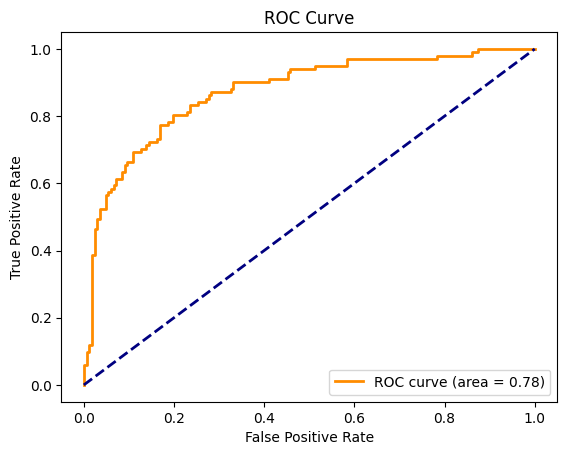

/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


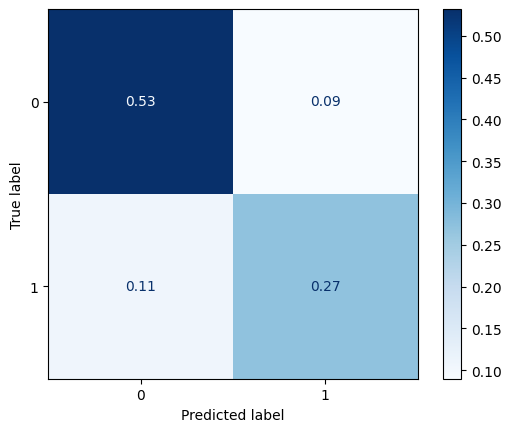

In [68]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, plot_confusion_matrix

def plot_roc_curve(falsePositiveRate, truePositiveRate, roc_auc):
    lw = 2
    plt.plot(falsePositiveRate, truePositiveRate, color='darkorange', lw=lw, label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

def validate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy = {}'.format(accuracy))

    precision = precision_score(y_test, y_pred)
    print('Precision = {}'.format(precision))

    recall = recall_score(y_test, y_pred)
    print('Recall = {}'.format(recall))

    f1Score = f1_score(y_test, y_pred)
    print('F1-Score = {}'.format(f1Score))

    roc_auc = roc_auc_score(y_test, y_pred) 
    y_prob = model.predict_proba(X_test)  
    y_prob = y_prob[:, 1]  
    falsePositiveRate, truePositiveRate, thresholds = roc_curve(y_test, y_prob) 
    plot_roc_curve(falsePositiveRate, truePositiveRate, roc_auc)

    plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, normalize = 'all')

from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)
validate_model(model, X_test, y_test)

In [ ]:


def predict(model, X):
    prediction = model.predict(X)

In [60]:
d = {
'PassengerId': [892.0000],
'TicketClass': [1],
'Sex': [1],
'Age': [34.5000],
'NumOfSiblingsAndSpouses': [0.0000],
'NumOfParentsAndChildren': [0.0000],
'Fare': [7.8292],
'PortOfEmbarkation': [2.0000],
}
abc = pd.DataFrame(data=d)
predict = model.predict(abc)
predict[0]

1

## Auswertung

Darstellung der Korrelationen zwischen `Survived` und den restlichen Columns:

<AxesSubplot: >

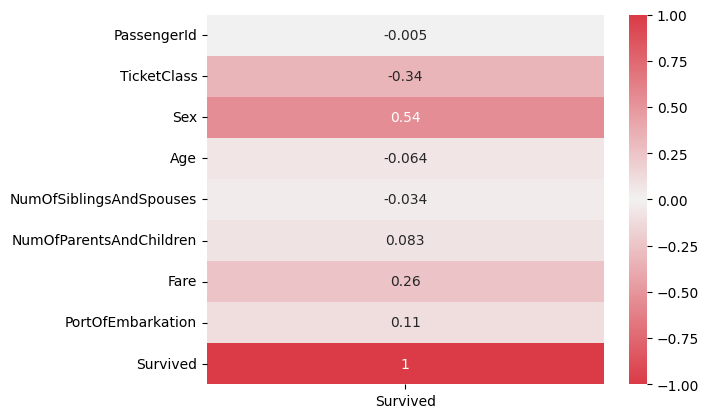

In [99]:
corr = df.corrwith(df['Survived'])
corr_df = pd.DataFrame({ 'Survived': corr }, index=df.columns)
cmap = sns.diverging_palette(10,10, as_cmap=True)
sns.heatmap(corr_df, annot=True, cmap=cmap, vmin=-1, vmax=1)